### Medal predictions

The purpose of this project, is to predict the number of medals a team/country may win in the summer olympics. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

In [2]:
tm = pd.read_csv('teams.csv')
tm.head()

,team,country,year,events,athletes,age,height,weight,medals,prev_medals,prev_3_medals
0,AFG,Afghanistan,1964,8,8,22.0,161.0,64.2,0,0.0,0.0
1,AFG,Afghanistan,1968,5,5,23.2,170.2,70.0,0,0.0,0.0
2,AFG,Afghanistan,1972,8,8,29.0,168.3,63.8,0,0.0,0.0
3,AFG,Afghanistan,1980,11,11,23.6,168.4,63.2,0,0.0,0.0
4,AFG,Afghanistan,2004,5,5,18.6,170.8,64.8,0,0.0,0.0


In [3]:
tm = tm[['team', 'country', 'year', 'athletes', 'age', 'prev_medals', 'medals']]
tm.head()

,team,country,year,athletes,age,prev_medals,medals
0,AFG,Afghanistan,1964,8,22.0,0.0,0
1,AFG,Afghanistan,1968,5,23.2,0.0,0
2,AFG,Afghanistan,1972,8,29.0,0.0,0
3,AFG,Afghanistan,1980,11,23.6,0.0,0
4,AFG,Afghanistan,2004,5,18.6,0.0,0


In [4]:
# look at which variables correlated with one another
tm.corr()['medals']

C:\Users\tshep\AppData\Local\Temp\ipykernel_36980\3012363599.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tm.corr()['medals']


year          -0.021603
athletes       0.840817
age            0.025096
prev_medals    0.920048
medals         1.000000
Name: medals, dtype: float64

C:\Users\tshep\AppData\Local\Temp\ipykernel_36980\3707059934.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(tm.corr(), annot=True)


<Axes: >

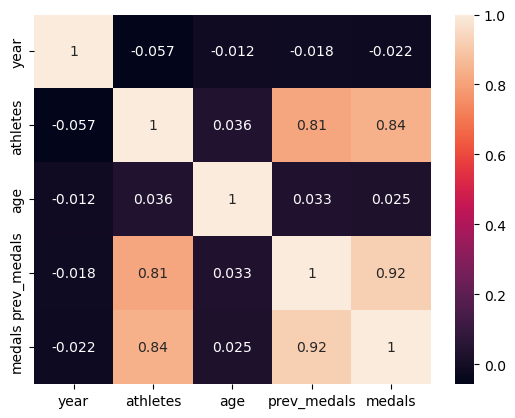

In [5]:
# use heatmap to visualise the correlations
sn.heatmap(tm.corr(), annot=True)

The athelets and medals values stronly correlate with one another, 
thus we can use these variables to predict the number of medals at team/country may win

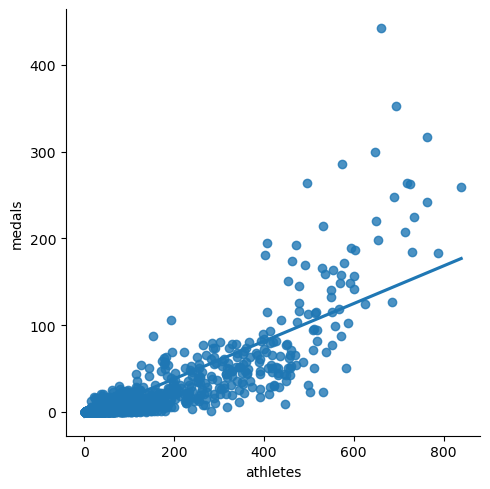

In [6]:
# plot a line plot for the athletes vs medals to see the relationship between the two

sn.lmplot(x='athletes', y ='medals', data=tm, fit_reg=True, ci=None)

As the number of athletes increase, the number of medals increase. Thus a country with more athletes , has a higher chances of winning more medals, than a country with less athletes. 

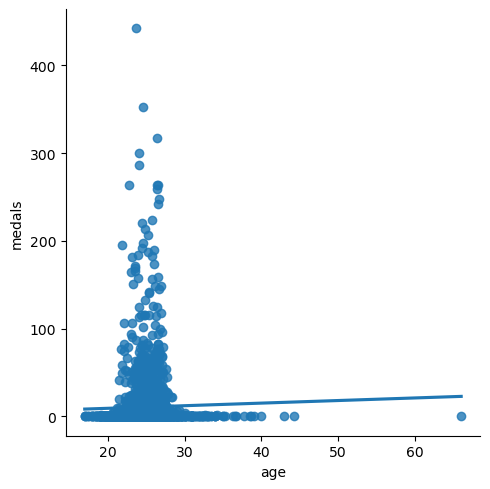

In [7]:
'''age has the lowest correlation to the medals, lets look at relationship between the age vs medals 
using a line graph'''

sn.lmplot(x='age', y='medals', data=tm, fit_reg=True, ci=None)


There's no linear relation between the age and medals, as the age increase the medals don't. Thus we won't use age for our predictive model. Its important to note that when the age is between 20 and 30 the number of medals increase.

<Axes: xlabel='medals', ylabel='Count'>

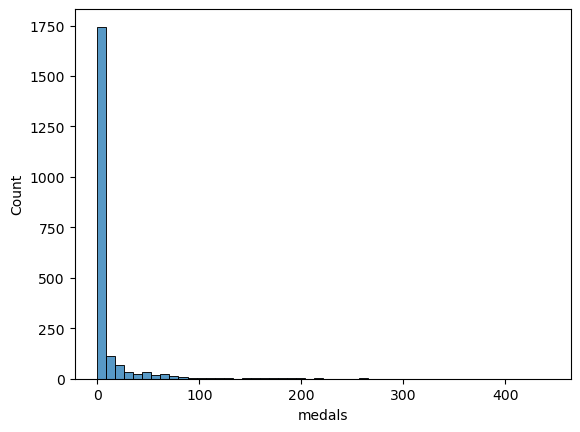

In [8]:

sn.histplot(data=tm, x='medals', bins=50)

looking at histogram, only a few countrys have won over 100 medals. Majority of countrys have 0 - 50. As we get close to the 100 medal mark, the number of countries decreases. This may affect the accurracy of over model.

# Data cleaning
Now is time to clean our data. 

In [9]:
# check id f our dataset has any null vaules.
tm.isnull().sum()

team             0
country          0
year             0
athletes         0
age              0
prev_medals    130
medals           0
dtype: int64

In [10]:
tm[tm.isnull().any(axis=1)]

,team,country,year,athletes,age,prev_medals,medals
19,ALB,Albania,1992,9,25.3,NaN,0
26,ALG,Algeria,1964,7,26.0,NaN,0
39,AND,Andorra,1976,3,28.3,NaN,0
50,ANG,Angola,1980,17,17.4,NaN,0
59,ANT,Antigua and Barbuda,1976,17,23.2,NaN,0
...,...,...,...,...,...,...,...
2092,VIN,Saint Vincent and the Grenadines,1988,6,20.5,NaN,0
2103,YAR,North Yemen,1984,3,27.7,NaN,0
2105,YEM,Yemen,1992,8,19.6,NaN,0
2112,YMD,South Yemen,1988,5,23.6,NaN,0


The prev_medals column has 130 nul values. The reason for the null vaules, is that the country didn't particapate in the previous summer Olympics.



##### Now we are going to drop the null values, as part of our data cleaning.

In [11]:
tm = tm.dropna()

In [12]:
tm.isnull().sum()

team           0
country        0
year           0
athletes       0
age            0
prev_medals    0
medals         0
dtype: int64

In [13]:
tm

,team,country,year,athletes,age,prev_medals,medals
0,AFG,Afghanistan,1964,8,22.0,0.0,0
1,AFG,Afghanistan,1968,5,23.2,0.0,0
2,AFG,Afghanistan,1972,8,29.0,0.0,0
3,AFG,Afghanistan,1980,11,23.6,0.0,0
4,AFG,Afghanistan,2004,5,18.6,0.0,0
...,...,...,...,...,...,...,...
2139,ZIM,Zimbabwe,2000,26,25.0,0.0,0
2140,ZIM,Zimbabwe,2004,14,25.1,0.0,3
2141,ZIM,Zimbabwe,2008,16,26.1,3.0,4
2142,ZIM,Zimbabwe,2012,9,27.3,4.0,0


### Building Our Model

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# our train dataset will compose of summer olympics before 2012, and the test dataset will have the all the summer olympics after 2012.
train_data = tm[tm['year'] < 2012].copy()
test_data = tm[tm['year'] >=2012].copy()

In [16]:
X=['athletes', 'prev_medals']
y='medals'

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
lin_reg = LinearRegression()

In [19]:
lin_reg.fit(train_data[X], train_data['medals'])

LinearRegression()

In [20]:
pred = lin_reg.predict(test_data[X])

In [21]:
# Add the predicitions to the test dataframe
test_data['pred'] = pred

In [22]:
test_data

,team,country,year,athletes,age,prev_medals,medals,pred
6,AFG,Afghanistan,2012,6,24.8,1.0,1,-0.961221
7,AFG,Afghanistan,2016,3,24.7,1.0,0,-1.176333
24,ALB,Albania,2012,10,25.7,0.0,0,-1.425032
25,ALB,Albania,2016,6,23.7,0.0,0,-1.711847
37,ALG,Algeria,2012,39,24.8,2.0,1,2.155629
...,...,...,...,...,...,...,...,...
2111,YEM,Yemen,2016,3,19.3,0.0,0,-1.926958
2131,ZAM,Zambia,2012,7,22.6,0.0,0,-1.640143
2132,ZAM,Zambia,2016,7,24.1,0.0,0,-1.640143
2142,ZIM,Zimbabwe,2012,9,27.3,4.0,0,1.505767


In [23]:
#convert any predictions that has a value less than zero to zero.

test_data.loc[test_data['pred'] < 0, 'pred'] = 0

In [24]:
# round the predictions values
test_data['pred'] = test_data['pred'].round()

In [25]:
test_data

,team,country,year,athletes,age,prev_medals,medals,pred
6,AFG,Afghanistan,2012,6,24.8,1.0,1,0.0
7,AFG,Afghanistan,2016,3,24.7,1.0,0,0.0
24,ALB,Albania,2012,10,25.7,0.0,0,0.0
25,ALB,Albania,2016,6,23.7,0.0,0,0.0
37,ALG,Algeria,2012,39,24.8,2.0,1,2.0
...,...,...,...,...,...,...,...,...
2111,YEM,Yemen,2016,3,19.3,0.0,0,0.0
2131,ZAM,Zambia,2012,7,22.6,0.0,0,0.0
2132,ZAM,Zambia,2016,7,24.1,0.0,0,0.0
2142,ZIM,Zimbabwe,2012,9,27.3,4.0,0,2.0


In [26]:
# import mean absolute error
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(test_data['medals'], test_data['pred'])

In [27]:
error

3.2987654320987656

In [28]:
tm.describe()

,year,athletes,age,prev_medals,medals
count,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000
mean,1995.227408,76.329692,24.812612,10.248759,10.990070
std,15.227727,129.799427,2.758258,31.951920,33.627528
min,1964.000000,1.000000,17.000000,0.000000,0.000000
25%,1984.000000,7.000000,23.300000,0.000000,0.000000
50%,1996.000000,21.000000,24.700000,0.000000,0.000000
75%,2008.000000,74.750000,26.100000,4.000000,5.000000
max,2016.000000,839.000000,66.000000,442.000000,442.000000


In [29]:
test_data[test_data['team'] == 'FRA']

,team,country,year,athletes,age,prev_medals,medals,pred
679,FRA,France,2012,426,26.6,77.0,82,86.0
680,FRA,France,2016,512,27.1,82.0,96,96.0


In [30]:
test_data[test_data['team'] == 'RSA']

,team,country,year,athletes,age,prev_medals,medals,pred
1660,RSA,South Africa,2012,145,25.4,1.0,9,9.0
1661,RSA,South Africa,2016,155,25.3,9.0,23,16.0


In [31]:
errors = (test_data['medals'] - test_data['pred']).abs()

In [32]:
# look at how many erros we got by team
error_by_team = errors.groupby(test_data['team']).mean()
error_by_team

team
AFG    0.5
ALB    0.0
ALG    1.5
AND    0.0
ANG    0.0
      ... 
VIE    1.0
VIN    0.0
YEM    0.0
ZAM    0.0
ZIM    1.0
Length: 204, dtype: float64

In [33]:
# look at how many medals a country earned on average

In [34]:
medals_by_team = test_data['medals'].groupby(test_data['team']).mean()
medals_by_team

team
AFG    0.5
ALB    0.0
ALG    1.5
AND    0.0
ANG    0.0
      ... 
VIE    1.0
VIN    0.0
YEM    0.0
ZAM    0.0
ZIM    0.0
Name: medals, Length: 204, dtype: float64

In [35]:
error_ratio = error_by_team / medals_by_team

In [36]:
error_ratio

team
AFG    1.0
ALB    NaN
ALG    1.0
AND    NaN
ANG    NaN
      ... 
VIE    1.0
VIN    NaN
YEM    NaN
ZAM    NaN
ZIM    inf
Length: 204, dtype: float64

The reason we have a lot of Nan values, is because alot of teams earn zero medals

In [37]:
error_ratio[~pd.isnull(error_ratio)]

team
AFG    1.000000
ALG    1.000000
ARG    0.853659
ARM    0.428571
AUS    0.367347
         ...   
USA    0.126953
UZB    0.625000
VEN    1.750000
VIE    1.000000
ZIM         inf
Length: 102, dtype: float64

In [38]:
# remove the infinte values 
error_ratio = error_ratio[np.isfinite(error_ratio)]

In [39]:
error_ratio

team
AFG    1.000000
ALG    1.000000
ARG    0.853659
ARM    0.428571
AUS    0.367347
         ...   
UKR    0.951220
USA    0.126953
UZB    0.625000
VEN    1.750000
VIE    1.000000
Length: 97, dtype: float64

<Axes: ylabel='Frequency'>

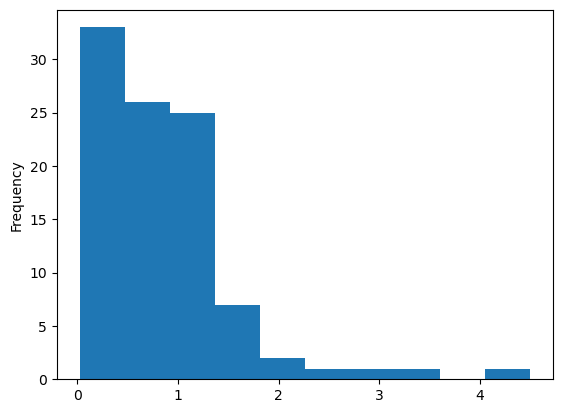

In [40]:
error_ratio.plot.hist()

In [41]:
error_ratio.sort_values()

team
FRA    0.022472
CAN    0.048387
NZL    0.063492
RUS    0.082353
ITA    0.121429
         ...   
MAR    2.000000
EGY    2.400000
HKG    3.000000
POR    3.333333
AUT    4.500000
Length: 97, dtype: float64

when predicting medals for countries that earn a lot of medals in the olympics are error is low. But for countries that don't 
complete in the Olympics as much and have a low number of athletes, our errror is high.

# Recommendations

### Ways to improve our model

1. Add in more predictors in the model, such as events, age, height.
2. Try different machine learning models
3. Reshape columns, as some columns have non linear correlations.